# TensorFlow 架構與主要功能

## Tensorflow 架構

* Tensorflow 執行環境包括三種版本：
  * TensorFlow: 一般電腦版本. 
  * TensorFlowjs: 網頁版本，適合邊緣運算的裝置及虛擬機裝置 (Docker/Kubernetes)
  * TensorFlow Lite: 輕量版，適合手機和物聯網裝置
* TensorFlow Keras 模組逐步整合以下模組及工具，列出幾個比較重要的可以去了解：
  * `GradientTape`: 低階梯度下降的訓練
  * `Dataset and Loader`: 資料集載入
  * `Callback`. 
  * `Estimator` 估計器. 
  * `Keras Application`: 預訓練好的模型. 
  * `Tensorflow Hub`: 進階的預訓練模型. 
  * `TensorBoard`: 視覺化工具
  * `TensorFlow Serving`: 部署工具

* 模型在運算時，正向傳導時，用到 `張量運算`，反向傳導時用到 `自動微分`
* 所以，這章就是要來介紹這兩個重要 component

## 張量運算 (Tensor)

In [3]:
# 載入套件
import tensorflow as tf

# 顯示版本
print(tf.__version__)

# 檢查 GPU 是否存在
# check cuda available
tf.config.list_physical_devices('GPU')

2.3.1


[]

### 宣告 tensor 常數(constant)，參數可以是常數、list、numpy array

In [4]:
# 宣告常數(constant)，參數可以是常數、list、numpy array
x = tf.constant([[1, 2]])

### 以四則運算符號計算

In [5]:
print(x+10)
print(x-10)
print(x*2)
print(x/2)

tf.Tensor([[11 12]], shape=(1, 2), dtype=int32)
tf.Tensor([[-9 -8]], shape=(1, 2), dtype=int32)
tf.Tensor([[2 4]], shape=(1, 2), dtype=int32)
tf.Tensor([[0.5 1. ]], shape=(1, 2), dtype=float64)


In [6]:
# 若要只顯示數值，需轉換為 NumPy Array
(x+10).numpy()

array([[11, 12]], dtype=int32)

In [7]:
type(x.numpy())

numpy.ndarray

### 使用 TensorFlow 函數

In [8]:
# 轉為負數
print(tf.negative(x))

# 常數、List、Numpy array 均可運算
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))

print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

# 混用四則運算符號及TensorFlow 函數
print(tf.square(2) + tf.square(3))

tf.Tensor([[-1 -2]], shape=(1, 2), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


### TensorFlow 會自動決定在 cpu or gpu 運算

* 一般而言，常數 (tf.constant) 放在 CPU，其他變數放在 GPU，兩者要加總時，會把常數搬到 GPU 再加總

In [8]:
x1 = tf.constant([[1, 2, 3]], dtype=float)
print("x1 是否在 GPU #0 上:  ", x1.device.endswith('GPU:0'))

# 設定 x 為均勻分配亂數 3x3
x2 = tf.random.uniform([3, 3])
print("x2 是否在 GPU #0 上:  ", x2.device.endswith('GPU:0'))

x3=x1+x2
print("x3 是否在 GPU #0 上:  ", x3.device.endswith('GPU:0'))

x1 是否在 GPU #0 上:   False
x2 是否在 GPU #0 上:   False
x3 是否在 GPU #0 上:   False


### 強制指定在cpu或gpu運算

* 用 `with tf.device("CPU:0")` 可以指定用 CPU 算，用 `with tf.device("GPU:0")`可以指定用 GPU 算

In [9]:
import time

# 計算 10 次的時間
def time_matmul(x):
    start = time.time()
    for loop in range(10):
        tf.matmul(x, x)

    result = time.time()-start
    print("{:0.2f}ms".format(1000*result))

# 強制指定在cpu運算
print("On CPU:", end='')
with tf.device("CPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)

# 強制指定在gpu運算
if tf.config.list_physical_devices("GPU"):
    print("On GPU:", end='')
    with tf.device("GPU:0"): 
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

On CPU:89.59ms


### 稀疏矩陣(sparse matrix)

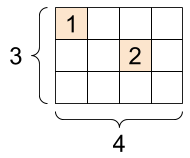

In [9]:
from IPython.display import Image
Image('./images/sparse matrix.png')

In [10]:
# 稀疏矩陣只需設定有值的位置及數值
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]], # 有值的位置
                                       values=[1, 2], # 值是多少
                                       dense_shape=[3, 4])
print(sparse_tensor)

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [11]:
# 轉為正常的矩陣格式
x = tf.sparse.to_dense(sparse_tensor)
print(type(x))

# 2.31 以前版本會出錯
x.numpy()

<class 'tensorflow.python.framework.ops.EagerTensor'>


array([[1, 0, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 0]], dtype=int32)

### 回歸 TF 1.x 版 Graph Execution Mode

* 如果要執行 Tensorflow 1.x 版 Graph Execution Mode 的程式，需 disable 2.x 版的功能，並改變仔入套件的 namespace
* 建議：  
  * tf 2.x 版的 Eager Execution Mode 已是主流，不要再用 1.x 版的 session 或 TFLearn 等舊架構  
  * 手邊如果是 1.x 版的 code ，可用官網 migration 指南做修改. 
  * 官網也有指令可以一次升級整個資料夾裡的舊 code

In [28]:
if tf.__version__[0] != '1':           # 是否為 TensorFlow 1.x版
    import tensorflow.compat.v1 as tf  # 改變載入套件的命名空間(Namespace)
    tf.disable_v2_behavior()           # 使 2.x 版功能失效(Disable)

Instructions for updating:
non-resource variables are not supported in the long term


In [29]:
# 測試1.x版程式
x = tf.constant([[1, 2]])
neg_x = tf.negative(x)

with tf.Session() as sess:   # 使用 session
    result = sess.run(neg_x)
    print(result)

[[-1 -2]]


### GPU記憶體管理

In [3]:
# 限制 TensorFlow 只能使用 GPU 2GB 記憶體
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:    
    try:
        # 限制 第一顆 GPU 只能使用 2GB 記憶體
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])
        
        # 顯示 GPU 個數
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # 顯示錯誤訊息
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Disable GPU

In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## 自動微分 (Automatic Differention)

### 單變量一階微分

* 如果宣告一個變數是 `tf.Variable()`，那就可以對他做自動微分

In [13]:
x = tf.Variable(3.0)         # 宣告 x 是一個 TensorFlow 變數(Variable)，目前的值是 3.0

with tf.GradientTape() as g: # 自動微分
    y = x * x                # y = x^2
    
dy_dx = g.gradient(y, x)     # 取得梯度， f'(x) = 2x, x=3 ==> 6

print(dy_dx.numpy())         # 轉換為 NumPy array 格式

6.0


* 但如果宣告一個變數是 `rf.constant()`，那如果要參與自動微分，還需額外設定 `g.watch()`

In [14]:
x = tf.constant(3.0)         # 宣告 TensorFlow 常數

with tf.GradientTape() as g: # 自動微分
    g.watch(x)               # 設定常數參與自動微分
    y = x * x                # y = x^2
    
dy_dx = g.gradient(y, x)     # 取得梯度， f'(x) = 2x, x=3 ==> 6

print(dy_dx.numpy())         # 轉換為 NumPy array 格式

6.0


### 單變量二階微分

* 就連做兩次，就是了：

In [15]:
x = tf.Variable(3.0)              
with tf.GradientTape() as g:      # 自動微分
    with tf.GradientTape() as gg: # 自動微分
        y = x * x                 # y = x^2
    dy_dx = gg.gradient(y, x)     # 一階導數
d2y_dx2 = g.gradient(dy_dx, x)    # 二階導數

print(f'一階導數={dy_dx.numpy()}, 二階導數={d2y_dx2.numpy()}') 

一階導數=6.0, 二階導數=2.0


* `tf.constant()` 也可以：

In [16]:
x = tf.constant(3.0)              # 宣告 TensorFlow 常數
with tf.GradientTape() as g:      # 自動微分
    g.watch(x)
    with tf.GradientTape() as gg: # 自動微分
        gg.watch(x)               # 設定常數參與自動微分
        y = x * x                 # y = x^2
        
    dy_dx = gg.gradient(y, x)     # 一階導數
d2y_dx2 = g.gradient(dy_dx, x)    # 二階導數

print(f'一階導數={dy_dx.numpy()}, 二階導數={d2y_dx2.numpy()}') 

一階導數=6.0, 二階導數=2.0


### 連鎖律

* 如果 $z = y^2$, $y = x^2$，那 $z = x^4$
* 我們可以計算 $dy/dx$，以及 $dz/dx$
* 作法如下：

In [17]:
x = tf.Variable(3.0)          # 宣告 TensorFlow 常數
with tf.GradientTape(persistent=True) as g:  # 自動微分
    y = x * x                 # y = x^2
    z = y * y                 # z = y^2
    
dz_dx = g.gradient(z, x)      # 4*x^3
dy_dx = g.gradient(y, x)      # 2*x

del g                         # 不用時可刪除 GradientTape 物件

print(f'dy/dx={dy_dx.numpy()}, dz/dx={dz_dx.numpy()}') 

dy/dx=6.0, dz/dx=108.0


* 這邊要注意，當我們要呼叫 `g.gradient()` 兩次以上(例如這邊示範，做了 dz/dx 和 dy/dx，做了兩次)，那在 `tf.GradientTape()` 要加上 `persistent = True` 這個參數

### pytorch 語法

* 順便認識一下 pytorch 的語法

In [18]:
import torch       # 載入套件

x = torch.tensor(3.0, requires_grad=True)  # 設定 x 參與自動微分
y=x*x              # y = x^2

y.backward()       # 反向傳導

print(x.grad)      # 取得梯度

tensor(6.)


### 實例：用自動微分來做簡單線性回歸

#### data

* 我們先自己生成一組資料: $y = 1.5x + 7 + e$， where $e \sim N(0, 1)$

In [80]:
import numpy as np
import matplotlib.pyplot as plt 

# 產生線性隨機資料100筆，介於 0-50
n = 100
X = np.linspace(0, 50, n) 
y = 1.5*X + 7 + np.random.uniform(-5, 5, n)

In [81]:
X

array([ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202,
        2.52525253,  3.03030303,  3.53535354,  4.04040404,  4.54545455,
        5.05050505,  5.55555556,  6.06060606,  6.56565657,  7.07070707,
        7.57575758,  8.08080808,  8.58585859,  9.09090909,  9.5959596 ,
       10.1010101 , 10.60606061, 11.11111111, 11.61616162, 12.12121212,
       12.62626263, 13.13131313, 13.63636364, 14.14141414, 14.64646465,
       15.15151515, 15.65656566, 16.16161616, 16.66666667, 17.17171717,
       17.67676768, 18.18181818, 18.68686869, 19.19191919, 19.6969697 ,
       20.2020202 , 20.70707071, 21.21212121, 21.71717172, 22.22222222,
       22.72727273, 23.23232323, 23.73737374, 24.24242424, 24.74747475,
       25.25252525, 25.75757576, 26.26262626, 26.76767677, 27.27272727,
       27.77777778, 28.28282828, 28.78787879, 29.29292929, 29.7979798 ,
       30.3030303 , 30.80808081, 31.31313131, 31.81818182, 32.32323232,
       32.82828283, 33.33333333, 33.83838384, 34.34343434, 34.84

In [82]:
y

array([ 4.61812511, 12.16599259,  4.31539025,  9.03148285,  9.5250196 ,
        8.67113559, 14.2165519 ,  9.24655017, 15.87767426, 17.45593215,
       17.37408171, 12.48262249, 15.00704669, 19.95183794, 17.73814556,
       22.28873757, 15.01163814, 20.81249455, 23.34883962, 25.65014262,
       20.83339149, 19.38510435, 19.90977851, 21.79934144, 26.53705319,
       21.56272476, 23.30661441, 32.04099293, 29.80046598, 28.6904976 ,
       25.8440825 , 27.85550798, 30.4930932 , 35.43366629, 36.85711751,
       35.59821868, 35.75688312, 36.69965731, 36.47518131, 33.32262397,
       37.29160658, 35.72160898, 39.10856461, 44.22372359, 43.87319053,
       43.31339787, 43.71046794, 38.03604079, 44.48362624, 42.98562593,
       41.67192309, 46.41266369, 44.18606575, 49.2070708 , 49.27225798,
       51.60477221, 45.82287064, 50.60181073, 46.10308375, 46.84366854,
       48.66358464, 52.82547167, 57.92276077, 52.80450067, 55.38157149,
       60.13861047, 53.13028287, 53.42494092, 59.50141804, 64.04

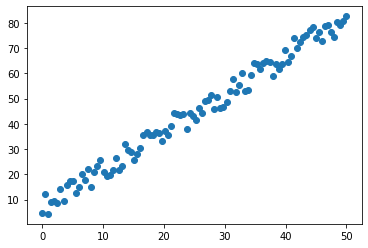

In [83]:
plt.scatter(X, y, label='data');

#### 定義問題

* 我們定義： $y_{hat}^{(i)} = w*x^{(i)} + b$，想要估 w 和 b
* 由 true model 可知，w=1.5, b=7，我們希望估出來的答案越接近越好

#### 定義訓練用函數

* 我們定義一個函數，是輸入 100 維的 X 向量後，可以輸出 100 維的 y 預測值：

In [84]:
# 定義預測值函數
def predict(X):
    return w * X + b 

* 然後，定義損失函數，去計算 MSE

In [85]:
# 定義損失函數
def loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred)) 

* 最後，是訓練用函數：

In [110]:
# 定義訓練函數
def train(X, y, epochs=10000, lr=0.001):
    current_loss=0                                # 損失函數值
    for epoch in range(epochs):                   # 執行訓練週期
        with tf.GradientTape() as t:              # 自動微分
            t.watch(tf.constant(X))               # 宣告 TensorFlow 常數參與自動微分
            current_loss = loss(y, predict(X))    # 計算損失函數值
        
        dw, db = t.gradient(current_loss, [w, b]) # 取得 w, b 個別的梯度

        # 更新權重：新權重 = 原權重 — 學習率(learning_rate) * 梯度(gradient)
        w.assign_sub(lr * dw) # w -= lr * dw
        b.assign_sub(lr * db) # b -= lr * db

        # 顯示每一訓練週期的損失函數
        if (epoch+1) % 500 == 0:
            print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, w: {w.numpy()}, b: {b.numpy()}') 

#### 開始訓練

In [111]:
# w、b 初始值均設為 0
w = tf.Variable(0.0)
b = tf.Variable(0.0)

# 執行訓練
train(X, y)

# w、b 的最佳解
print(f'w={w.numpy()}, b={b.numpy()}')

Epoch 499, Loss: 15.45288372039795, w: 1.6650562286376953, b: 1.597375512123108
Epoch 999, Loss: 12.553118705749512, w: 1.629228949546814, b: 2.7972848415374756
Epoch 1499, Loss: 10.806967735290527, w: 1.6014271974563599, b: 3.728408098220825
Epoch 1999, Loss: 9.755481719970703, w: 1.5798529386520386, b: 4.450960159301758
Epoch 2499, Loss: 9.122313499450684, w: 1.563111662864685, b: 5.011654853820801
Epoch 2999, Loss: 8.741037368774414, w: 1.5501203536987305, b: 5.446751594543457
Epoch 3499, Loss: 8.51144027709961, w: 1.540039300918579, b: 5.784387111663818
Epoch 3999, Loss: 8.373186111450195, w: 1.5322160720825195, b: 6.046396255493164
Epoch 4499, Loss: 8.289933204650879, w: 1.5261454582214355, b: 6.249708652496338
Epoch 4999, Loss: 8.239802360534668, w: 1.5214346647262573, b: 6.407477378845215
Epoch 5499, Loss: 8.209613800048828, w: 1.5177792310714722, b: 6.529905319213867
Epoch 5999, Loss: 8.191433906555176, w: 1.5149424076080322, b: 6.624911785125732
Epoch 6499, Loss: 8.18048763275

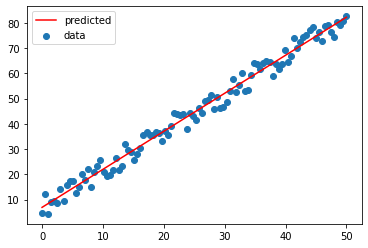

In [112]:
plt.scatter(X, y, label='data')
plt.plot(X, predict(X), 'r-', label='predicted')
plt.legend()

#### 用 keras 直接解

In [121]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

layer1 = Dense(units = 1, input_shape = [1])

model = Sequential([
    layer1
])
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam()
)
history = model.fit(X, y, epochs=1000, verbose = False)

* 看一下訓練過程：

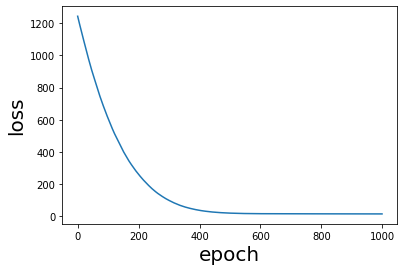

In [122]:
plt.plot(history.history['loss']);
plt.xlabel('epoch', fontsize=20);
plt.ylabel("loss", fontsize=20);

* 取得模型參數

In [123]:
w = layer1.get_weights()[0][0][0]
b = layer1.get_weights()[1][0]

print(f"w：{w:.4f} , b：{b:.4f}")

w：1.6639 , b：1.6600
